# TFM: Naturgy Sentiment Analysis

In this project, we utilized a Python virtual environment to maintain an isolated and controlled setting for the dependencies and packages used. This allowed us to work while avoiding conflicts between package versions and libraries.

##  **1. Libraries**

Libraries for data analysis, numerical computation, file manipulation, and task progress tracking.




In this initial section of the work, a series of preparations and essential configurations were carried out to perform sentiment analysis on Naturgy-related data. Below is a detailed description of the actions taken:

### Importing Libraries and Functions

For sentiment analysis, various libraries and key functions were imported. These libraries included tools for text processing, data analysis, training machine learning models, and visualization of results. Among the important libraries are Pandas, NumPy, Matplotlib, Scikit-Learn, and TensorFlow.
  
* pandas: Data analysis library
* numpy: Library for numerical and scientific computation
* tensorflow: Platform for building and training machine learning models
* sklearn: Library for machine learning in Python. NearestNeighbors is an algorithm for nearest neighbor search, and train_test_split is used to split the data.
* pickle: Module for serialization and deserialization of Python objects.
* matplotlib: Library for data visualization in Python. pyplot is the module for creating graphs and images.
* tqdm: Library for adding progress bars to iterations.
* sentence_transformers: A framework for state-of-the-art sentence, text, and image embedding.
* SciPy: A Python library for mathematics, science, and engineering that provides modules for optimization, linear algebra, integration, interpolation, and other scientific and engineering tasks.
* re: A Python module allowing text search and manipulation using regular expressions.
* tpot: An open-source Python library that utilizes genetic programming to automate the process of finding the best machine learning pipelines for a given dataset.
* unicodedata: A Python module that provides functions for working with Unicode characters, such as normalization and obtaining character properties.
* nltk: A natural language processing (NLP) library in Python that offers tools and resources for tasks like tokenization, syntactic analysis, and text processing in natural language.
* emoji: A Python library providing a set of functions for working with emojis, including searching and manipulating emojis in text strings.
* os: Allows access to operating system-dependent functionalities.
* time: A module in Python that provides functions for working with time and the system clock, such as time measurement, pausing program execution, and managing timestamps.

















In [ ]:
from tqdm import tqdm
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import tensorflow_hub as hub
import tensorflow_text as text
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from sentence_transformers.util import community_detection
from tpot import TPOTClassifier
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import emoji
import os
import win32api, win32con
import time

### Stopwords Configuration and Variables


A list of Spanish stopwords was configured using the Natural Language Toolkit (NLTK) library to enhance the quality of text analysis. Stopwords refer to common words that are often removed during text processing as they do not contribute significant information. Additionally, useful variables were defined, such as the target directory for saving files.

In [ ]:
# stopwords
nltk.download('stopwords')
stop_words = set(word for word in stopwords.words('spanish') if not word.startswith('n'))

[nltk_data] Downloading package stopwords to C:\Users\Yuriy
[nltk_data]     Popryshko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# dirección por defecto:
direction = f"C:\\Users\\{os.getenv('username')}\\Downloads\\"

##### **Definition of Dictionaries**

Dictionaries were created to associate numbers with relevant labels. For instance, the "pred_dict" dictionary established relationships between numerical values and sentiment labels, such as "NEGATIVE" or "POSITIVE." This facilitated the interpretation of sentiment analysis results. Additionally, dictionaries were crafted to translate names of days, seasons, and months into Spanish. These dictionaries aimed to assist in mapping and understanding various temporal references within the data.

In [ ]:
pred_dict = {
    0: "MIXED",
    1: "NEGATIVE",
    2: "NEUTRAL",
    3: "POSITIVE"
}

cluster_dic = {
    0: "negative",
    1: "mixed - positive",
    2: "positive",
    3: "mixed - negative"
}

days_in_spanish = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}


seasons_in_spanish = {
    1: 'invierno',
    2: 'primavera',
    3: 'verano',
    4: 'otoño'
}

months_in_spanish = {
    1: 'enero',
    2: 'febrero',
    3: 'marzo',
    4: 'abril',
    5: 'mayo',
    6: 'junio',
    7: 'julio',
    8: 'agosto',
    9: 'septiembre',
    10: 'octubre',
    11: 'noviembre',
    12: 'diciembre'
}

##### **Custom Functions**

A personalized function named "plot_train_val" was defined with the aim of automating the generation of graphs that display loss during the training of deep learning models. Additionally, a function called "clean_comments" was created specifically to handle text cleaning within Naturgy's comments. This cleaning process involved removing special characters, converting text to lowercase, excluding stopwords, and performing other essential text cleaning tasks to prepare comments for sentiment analysis. These functions were designed to streamline and standardize specific tasks within the analysis pipeline.

In [ ]:
# gráfico train-validation para NN
def plot_train_val(history, lim1, lim2):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim(lim1, lim2)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [ ]:
# función para limpieza de comentarios
def clean_comments(text, excl=True):

    # Task 1: Define a new column to indicate if comment has exclamations or question marks
    if excl:
        has_exclamation_or_question = any(c in text for c in ('!', '¿', '?'))

    # Task 2: Convert all tokens to lowercase
    text = text.lower()

    # Task 3: convertir emojis en definición suya (necesario antes de quitar caracteres extraños)
    text = emoji.demojize(text, language='es')

    # Task 4: Convert tokens to Unicode, excluding those with 'ñ'
    text = ''.join(c if c == 'ñ' or ord(c) < 128 else unicodedata.normalize('NFKD', c)[0] for c in text)

    # Task 5: Replace tokens including 'http' with 'http'
    text = re.sub(r'\bhttp\S+', 'http', text)

    # Task 6: Substitute non-alphabetical characters with a space
    text = re.sub(r'[^a-zA-Zñ]', ' ', text)

    # Task 7: Replace double spaces with single spaces
    text = re.sub(r'\s+', ' ', text)

    # Task 8: Eliminate stopwords except those starting with 'n'and tokens with len == 1
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
    text = ' '.join(filtered_words)

    if excl:
        return text, has_exclamation_or_question
    else:
        return text

##### **Data Reading**

An attempt was made to read data from a Parquet file using the Pandas library. These data were associated with Naturgy and were crucial for sentiment analysis. In the event of encountering any issues while reading the Parquet file, an appropriate error message would be displayed to address the problem. This approach aimed to ensure the successful retrieval of essential data for the sentiment analysis process and handle any potential errors that might arise during the reading operation.

In [ ]:
try:
    df = pd.read_parquet("naturgy_tfm.parquet", engine ='pyarrow')
except:
    win32api.MessageBox(0, "Something went wrong reading the parquet file", "Reading Parquet...", win32con.MB_OK)

In summary, this initial section aimed to establish a robust foundation for sentiment analysis within Naturgy's data. The actions performed included setting up the development environment, importing key libraries, configuring essential variables, creating custom functions, and reading the necessary data. These preparations are crucial for conducting effective analysis in subsequent sections.

## **2. Cleaning**

In the section labeled "Cleaning" of this work, several fundamental operations were conducted to prepare Naturgy's data before proceeding with sentiment analysis. The following actions were performed:

##### **Duplicate Removal**

Duplicate records were eliminated based on the unique identifier "ID_ENCUESTA." This ensured that each comment was accounted for only once in the dataset, preventing redundancies.

In [ ]:
# eliminamos duplicados:
df.drop_duplicates(subset='ID_ENCUESTA', keep='first', inplace=True)

#### **Sentiment Analysis by Category**

A specific sentiment analysis was conducted for each category within "DES_MOTIVO_SR." Comments were grouped, and the frequencies of positive and negative sentiments were counted within each category. Subsequently, stacked bar graphs were generated to visualize these results.

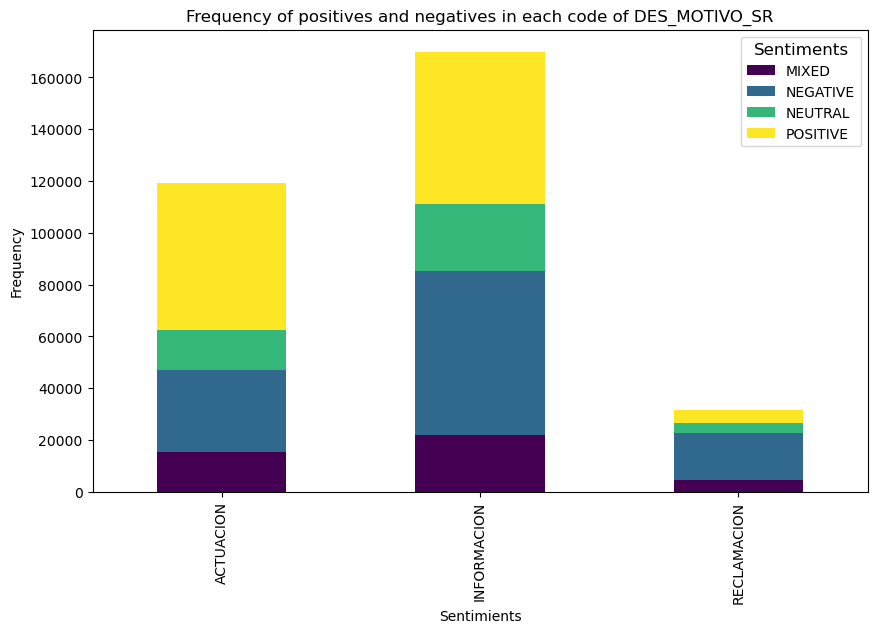

In [ ]:
grouped_data = df.groupby(['DES_MOTIVO_SR', 'SENTIMENT']).size().unstack(fill_value=0)

# Create the bar plot
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Add labels and title
plt.xlabel('Sentimients')
plt.ylabel('Frequency')
plt.title('Frequency of positives and negatives in each code of DES_MOTIVO_SR')
plt.legend(title='Sentiments', title_fontsize=12)

# Show the plot
plt.show()

cat_mapping = {'INFORMACION': 0, 'ACTUACION': 1, 'RECLAMACION': 2}
df['DES_MOTIVO_SR_enc'] = df['DES_MOTIVO_SR'].map(cat_mapping)

#### **Cleaning and Date Transformation**

Cleaning and transformation operations were performed on the date columns "fecha_inicio" and "fecha_cierre." Missing values were imputed using a Random Forest model, allowing the retention of data rather than discarding it. Additionally, new columns were created to provide detailed information about the dates, such as the year, month, day of the week, season, and whether it was a weekend or not.

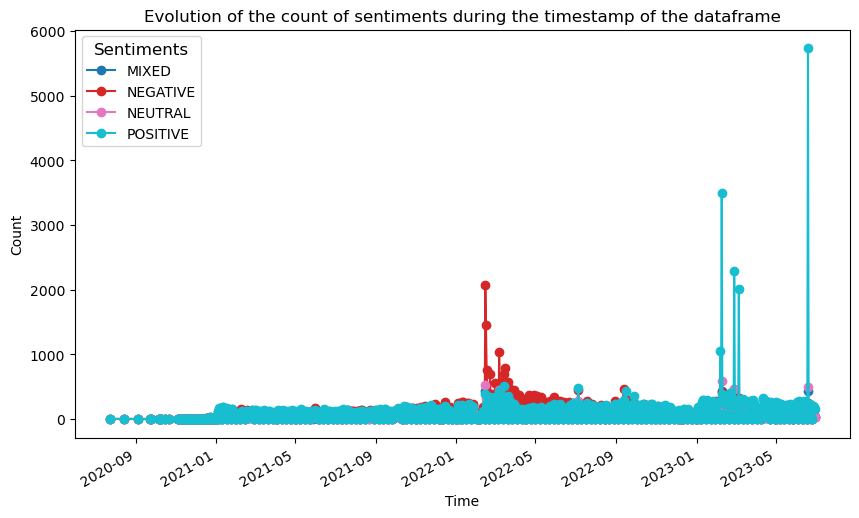

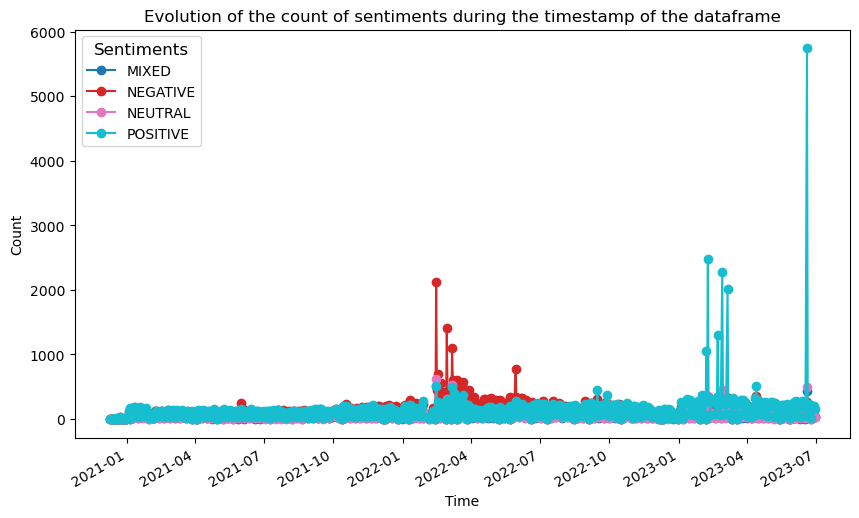

% de comentarios no resueltos en el mismo día: 10.12


In [ ]:
# revisión e imputación de perdidos en las variables de fecha, así como creación de nuevas columnas:
df.rename(columns={'ID_FEC_CREACION': 'fecha_inicio', 'ID_FEC_CIERRE': 'fecha_cierre'}, inplace=True)

lista = ['2023-01-01', '2023-01-06', '2023-05-01', '2023-08-15', '2023-10-12', '2023-11-01', '2023-12-06', '2023-12-25']


for col in ['fecha_inicio', 'fecha_cierre']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

##########################################################################################################
    # realizo zo un RF para imputar los datos perdidos (son un 10%, mucho pa descartarlos)


    # Separate rows with missing and non-missing time data
    df_missing = df[df[col].isnull()]
    df_valid = df[df[col].notnull()]

    # Split the valid data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df_valid[['DES_MOTIVO_SR_enc', 'ID_RECOMENDACION', 'ID_SATISFACCION']], df_valid[col], test_size=0.2, random_state=42)

    # Build a RandomForestClassifier for imputation
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train.values.reshape(-3, 3), y_train)  # Reshape to make it a 2D array

    # Predict missing time data based on the sentiment category
    predicted_time_data = rf_classifier.predict(df_missing[['DES_MOTIVO_SR_enc', 'ID_RECOMENDACION', 'ID_SATISFACCION']].values.reshape(-3, 3))

    # Fill the missing time data with the predicted values
    df.loc[df[col].isnull(), col] = predicted_time_data


    df[f'year {col}'] = df[col].dt.year   # lo dejo en inglés por la ñ
    df[f'mes {col}'] = df[col].dt.month.map(months_in_spanish)
    df[f'dia_semana {col}'] = df[col].dt.strftime('%A').map(days_in_spanish)
    df[f'estacion {col}'] = df[col].dt.quarter.map(seasons_in_spanish)
    df[f'fin_de_semana {col}'] = ((df[col].dt.weekday > 4) | (df[col].dt.strftime('%Y-%m-%d').isin(lista)))

    grouped_data = df.groupby([col, 'SENTIMENT']).size().unstack(fill_value=0)

    # Create the line plot
    ax = grouped_data.plot(kind='line', marker='o', figsize=(10, 6), colormap='tab10')

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.title('Evolution of the count of sentiments during the timestamp of the dataframe')
    plt.legend(title='Sentiments', title_fontsize=12)

    # Show the plot
    plt.show()

df['date_difference'] = (df['fecha_cierre'] - df['fecha_inicio']).dt.days.astype('int64')

print(f"% de comentarios no resueltos en el mismo día: {round(100*len(df[df['date_difference'] > 1])/len(df), 2)}")

In [ ]:
df.head()

,ID_ENCUESTA,ID_CODIGO_SR,fecha_inicio,fecha_cierre,DES_MOTIVO_SR,DES_PROCESO,DES_TIPO_SR,DES_COMENTARIOS,ID_SATISFACCION,ID_RECOMENDACION,...,mes fecha_inicio,dia_semana fecha_inicio,estacion fecha_inicio,fin_de_semana fecha_inicio,year fecha_cierre,mes fecha_cierre,dia_semana fecha_cierre,estacion fecha_cierre,fin_de_semana fecha_cierre,date_difference
0,29690267,I2-27904984237,2022-05-10,2022-05-10,INFORMACION,Cobro,Información general sobre el cobro,"Pues se podria haber resuelto mucho antes, si ...",10,7,...,mayo,Martes,primavera,False,2022,mayo,Martes,primavera,False,0
1,30519045,A2-28369696133,2022-07-22,2022-07-22,ACTUACION,Mantenimiento de Clientes,Modificación datos del titular,"La operadora ha estado perfecta. El problema, ...",10,10,...,julio,Viernes,verano,False,2022,julio,Viernes,verano,False,0
2,27326806,I2-26572476346,2021-10-05,2021-10-05,INFORMACION,Facturación,Información general sobre la facturación,Pérdida de tiempo. Es imposible hablar con nad...,0,0,...,octubre,Martes,otoño,False,2021,octubre,Martes,otoño,False,0
3,27041555,A2-26412378319,2021-09-04,2021-09-04,ACTUACION,Contratación del Servicio,Cambio de producto/tarifa/mercado,Si ha sido positiva y rápida,10,10,...,septiembre,Sábado,verano,True,2021,septiembre,Sábado,verano,True,0
4,29230060,I2-27681001055,2022-04-04,2022-04-04,INFORMACION,Facturación,Información general sobre la facturación,Pues no los recomendaría porque las facturas m...,0,0,...,abril,Lunes,primavera,False,2022,abril,Lunes,primavera,False,0


#### **Comment Cleaning and Length Analysis**

A cleaning function was applied to the comments using the previously defined approach. Furthermore, the lengths of the cleaned comments were calculated, and a bar graph was generated to display the average length of comments based on sentiment.

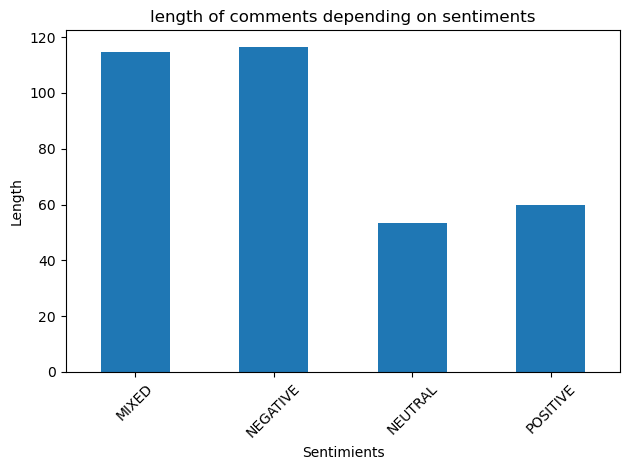

In [ ]:
# limpieza de comentarios y guardado:

# Apply the function to each comment
df['comments_cleaned'], df['has_exclamation_or_question'] = zip(*df['DES_COMENTARIOS'].map(clean_comments))

df['comments_length'] = df['comments_cleaned'].apply(lambda x: len(x))

mean_values = df.groupby('SENTIMENT')['comments_length'].mean()

ax = mean_values.plot(kind='bar')

plt.xlabel('Sentimients')
plt.ylabel('Length')
plt.title('length of comments depending on sentiments')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df.head()

,ID_ENCUESTA,ID_CODIGO_SR,fecha_inicio,fecha_cierre,DES_MOTIVO_SR,DES_PROCESO,DES_TIPO_SR,DES_COMENTARIOS,ID_SATISFACCION,ID_RECOMENDACION,...,fin_de_semana fecha_inicio,year fecha_cierre,mes fecha_cierre,dia_semana fecha_cierre,estacion fecha_cierre,fin_de_semana fecha_cierre,date_difference,comments_cleaned,has_exclamation_or_question,comments_length
0,29690267,I2-27904984237,2022-05-10,2022-05-10,INFORMACION,Cobro,Información general sobre el cobro,"Pues se podria haber resuelto mucho antes, si ...",10,7,...,False,2022,mayo,Martes,primavera,False,0,pues podria haber resuelto si operador dicho m...,True,153
1,30519045,A2-28369696133,2022-07-22,2022-07-22,ACTUACION,Mantenimiento de Clientes,Modificación datos del titular,"La operadora ha estado perfecta. El problema, ...",10,10,...,False,2022,julio,Viernes,verano,False,0,operadora perfecta problema incomprensible hoy...,False,155
2,27326806,I2-26572476346,2021-10-05,2021-10-05,INFORMACION,Facturación,Información general sobre la facturación,Pérdida de tiempo. Es imposible hablar con nad...,0,0,...,False,2021,octubre,Martes,otoño,False,0,perdida tiempo imposible hablar nadie realment...,False,153
3,27041555,A2-26412378319,2021-09-04,2021-09-04,ACTUACION,Contratación del Servicio,Cambio de producto/tarifa/mercado,Si ha sido positiva y rápida,10,10,...,True,2021,septiembre,Sábado,verano,True,0,si sido positiva rapida,False,23
4,29230060,I2-27681001055,2022-04-04,2022-04-04,INFORMACION,Facturación,Información general sobre la facturación,Pues no los recomendaría porque las facturas m...,0,0,...,False,2022,abril,Lunes,primavera,False,0,pues no recomendaria facturas llegan elevadas ...,False,177


#### **Saving the Clean Dataset**

Finally, unnecessary columns were removed, and the clean dataset was saved into a Parquet file for subsequent use in sentiment analysis.

In [ ]:
# guardamos el archivo limpio
df.drop(columns=['DES_MOTIVO_SR_enc', 'DES_TIPO_SR', 'DES_PROCESO', 'ID_CODIGO_SR', 'DES_COMENTARIOS'], inplace=True)

df.to_parquet('naturgy_tfm_limpio.parquet')

These cleaning and preparation operations are crucial to ensure the quality and usefulness of Naturgy's data before proceeding with sentiment analysis.






###  **3. Application of Deep Learning Techniques**

Given that this report focuses on sentiment analysis of customer comments regarding received telephone service, it's essential to understand some basic concepts such as NLP (Natural Language Processing). It's a branch of Artificial Intelligence that enables computers to manipulate natural language texts or speeches. It relies on machine learning with the aim of extracting user opinions. This technology has evolved significantly, leading to new techniques like 'Deep Learning,' a technique we've chosen to utilize in this work. Deep Learning is a subfield of machine learning based on the construction and training of artificial neural networks. It allows data clustering for highly accurate predictions and is based on the operation and structure of human brain neurons. To conduct sentiment analysis, we've decided to employ a series of Deep Learning techniques in this report.

The two techniques chosen for this analysis are Sentence Transformer and BERT, which we will explain further below.


### **4. Segmentation**

Firstly, for data segmentation, we utilized the Sentence Transformers library specialized in natural language processing and deep learning for text and sentence representation in the form of vectors.

After converting sentences, we tested various pre-trained models using Spanish texts to determine which yielded the best results. For this purpose, we assessed the quality of sentences through 'Performance Sentence Embeddings.' This allows us to understand and process text more effectively by evaluating and measuring the performance of embeddings.

All tested models were specifically trained for semantic search: given a search query/question, these models can find relevant text fragments. This approach is valuable in this analysis to classify keywords that might have multiple interpretations. 



###  **Embeddings**

After experimenting with various pre-trained multilingual language models, we settled on the "distiluse-base-multilingual-cased-v1" model designed to understand and represent text in multiple languages, including Spanish. This model is used to generate embeddings or vector representations of text comments within the data. We chose this model due to its speed in providing results.

The process involves taking batches of clean comment texts from the "comments_cleaned" column, encoding them into vector representations using the model. These vector representations are stored in a list and then converted into a numpy array for subsequent analysis.


In [ ]:
# modelo entrenado en español (además de otros idiomas)
model_name = 'distiluse-base-multilingual-cased-v1'
model = SentenceTransformer(model_name)

In [ ]:
# Tamaño del lote (batch size)
batch_size = 5000

# Obtener el número total de textos
num_texts = len(df)

# Inicializar una lista para almacenar las representaciones vectoriales
document_embeddings = []

# Codificar los textos en lotes
for start_index in range(0, num_texts, batch_size):
    end_index = min(start_index + batch_size, num_texts)
    batch_texts = df['comments_cleaned'][start_index:end_index].tolist()
    batch_embeddings = model.encode(batch_texts)
    document_embeddings.extend(batch_embeddings)

# Convertir la lista de representaciones vectoriales en un array numpy
document_embeddings = np.array(document_embeddings)

###  **Clustering**

Once the model was pre-trained, we employed the KMeans algorithm to group the data into clusters based on the previously generated vector representations. After several trials, we ultimately settled on clustering into 4 clusters, which yielded the best result.

The code assigns each comment to one of the clusters, allowing data segmentation into similar groups. Examples of comments within each cluster are printed to gain a better understanding of the types of comments grouped together.

In [ ]:
# probar la clusterización de los embeddings
num_clusters = 4
clustering_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=500, n_init=3)
clustering_model.fit(document_embeddings)
cluster_assignment = clustering_model.labels_

df['cluster'] = cluster_assignment

In [ ]:
# ejemplos de clusters
for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(df[df['cluster'] == i]['comments_cleaned'].values, "\n")

Cluster 0:
['si sido positiva rapida' 'atencion personal perfecta'
 'puta mierda naturgy' ... 'agradables explican bien duda'
 'valoro atencion esfuerzo entender intereses valorar puntuacion gracias'
 'no recomiendo ninguna manera experiencia mala'] 

Cluster 1:
['operadora perfecta problema incomprensible hoy dia no puedo dado alta tener mismo correo electronico dos propiedades diferentes casos contrato nombre mujer'
 'pues no recomendaria facturas llegan elevadas puesto servicios no contrate facturas no llegan meses demasiado si no resuelven cambiare empresa ofrece mejor servicio menos dinero'
 'positiva operadora confirmado si contrato compensacion excedentes solares mantiene tarifa compromiso centimos kilovatio hora'
 ...
 'pues dudoso trato bueno aun esperando arregle error cambio contrato llevo semanas esperando'
 'descontenta servicio facturacion pensando cambiar compañia'
 'atendido siempre rapido explicado cualquier duda no entendia muchas modalidades contratos pueden ajustar 

In [ ]:
# Utilizamos el método 'map' para aplicar el mapeo y crear una nueva serie:
df['cluster'] = df['cluster'].map(cluster_dic)

df['cluster'].value_counts()

cluster
mixed - positive    115241
negative             85818
positive             68985
mixed - negative     50816
Name: count, dtype: int64

In [ ]:
# Comprobamos los porcentajes de sentimientos que hay en cada cluster para ver si estos son representativos y tienen diferencia entre sí
table = df.pivot_table(index='cluster', columns='SENTIMENT', aggfunc='size', fill_value=0)
table_percentage = table.div(table.sum(axis=1), axis=0) * 100

print(table_percentage)

SENTIMENT             MIXED   NEGATIVE    NEUTRAL   POSITIVE
cluster                                                     
mixed - negative  10.215287  22.644443  13.832258  53.308013
mixed - positive  15.467585  56.492047  14.279640  13.760728
negative           5.047892   9.357011  16.657345  68.937752
positive          20.184098  41.203160  11.677901  26.934841


###  **Community detection**

This subsection continues to explore community detection within the comments using the previously generated vector representations. Similar to the previous step, community detection techniques are applied to cluster the comments into communities based on content similarity.

The code creates a dictionary that assigns each comment to a specific community and adds this information as a new column named "community" in the DataFrame. The formed communities are explored, showcasing how comments are grouped within these communities.

In summary, this section of the work utilizes advanced techniques for processing similarity relationships. In this specific case, given the text data we have, it might not be effectively feasible.


In [ ]:
# communities = community_detection(
#     document_embeddings, threshold=0.5, min_community_size=2, batch_size=1024
# )

# # Crear un diccionario para almacenar las asignaciones de comunidades por índice
# community_dict = {}

# for i, comm in enumerate(communities):
#     for ind in comm:
#         community_dict[ind] = i  # Asignar la comunidad correspondiente al índice

# # Crear una nueva columna 'community' en el DataFrame basada en el diccionario de asignaciones
# df['community'] = df.index.map(community_dict.get)

# # Llenar los valores NaN en la columna 'community' con -1
# df['community'].fillna(-1, inplace=True)

# for i, comm in enumerate(communities):
#     print('_' * 50)
#     print(f'community: {i}, size: {len(comm)}')
#     print('\n'.join([batch_texts[ind] for ind in comm]))
#     print()


In [ ]:
# como vemos, se forman pocas comunidades con muy pocos valores (posiblemente por los límites del vocabulario español entrenado en el modelo)
# df['community'].value_counts()

## **5. Sentiment Classification**

This section involved a series of essential tasks to prepare the data for subsequent sentiment analysis.

###  **Preprocessing**

In this segment, a series of crucial processes are undertaken to prepare the data for further analysis and modeling. Firstly, columns that are not deemed relevant for the study are removed. Subsequently, a backup copy of the original data is created, ensuring data safety.

The next step involves converting categorical labels into numerical values. This is pivotal since many machine learning algorithms require numerical data to operate. To achieve this, a process known as "label encoding" is utilized.

Finally, crucial information about the dataset is provided, such as its size and the types of data present. This summary is essential for understanding the nature of the data to be worked on in later stages of the project.

In [ ]:
# Eliminamos columnas y realizamos label encoding

# copia por seguridad
df1 = df.copy()

df.drop(columns=['ID_ENCUESTA', 'fecha_inicio', 'fecha_cierre'], inplace=True)



label_encoder = LabelEncoder()

for col in ['DES_MOTIVO_SR', 'fin_de_semana fecha_inicio', 'fin_de_semana fecha_cierre', 'estacion fecha_inicio', 'estacion fecha_cierre', 'mes fecha_inicio', 'mes fecha_cierre',
            'dia_semana fecha_inicio', 'dia_semana fecha_cierre', 'has_exclamation_or_question', 'cluster', 'SENTIMENT']:
    df[col] = label_encoder.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320860 entries, 0 to 337630
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DES_MOTIVO_SR                320860 non-null  int64  
 1   ID_SATISFACCION              320860 non-null  float64
 2   ID_RECOMENDACION             320860 non-null  float64
 3   SENTIMENT                    320860 non-null  int64  
 4   year fecha_inicio            320860 non-null  float64
 5   mes fecha_inicio             320860 non-null  int64  
 6   dia_semana fecha_inicio      320860 non-null  int64  
 7   estacion fecha_inicio        320860 non-null  int64  
 8   fin_de_semana fecha_inicio   320860 non-null  int64  
 9   year fecha_cierre            320860 non-null  float64
 10  mes fecha_cierre             320860 non-null  int64  
 11  dia_semana fecha_cierre      320860 non-null  int64  
 12  estacion fecha_cierre        320860 non-null  int64  
 13  fin_

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320860 entries, 0 to 337630
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DES_MOTIVO_SR                320860 non-null  int64  
 1   ID_SATISFACCION              320860 non-null  float64
 2   ID_RECOMENDACION             320860 non-null  float64
 3   SENTIMENT                    320860 non-null  int64  
 4   year fecha_inicio            320860 non-null  float64
 5   mes fecha_inicio             320860 non-null  int64  
 6   dia_semana fecha_inicio      320860 non-null  int64  
 7   estacion fecha_inicio        320860 non-null  int64  
 8   fin_de_semana fecha_inicio   320860 non-null  int64  
 9   year fecha_cierre            320860 non-null  float64
 10  mes fecha_cierre             320860 non-null  int64  
 11  dia_semana fecha_cierre      320860 non-null  int64  
 12  estacion fecha_cierre        320860 non-null  int64  
 13  fin_

In this section, the dataset columns are adjusted to have a uniform scale, making them easier to compare—a crucial step for subsequent analysis and modeling. This is achieved using a technique called "StandardScaler."

In [ ]:
# Normalizamos columnas:
columns_to_exclude = ['comments_cleaned', 'SENTIMENT']
columns_to_scale = [col for col in df.columns if col not in columns_to_exclude]
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

Next, the cleaned text is prepared for further analysis. A technique called "TF-IDF Vectorization" is employed to convert the text into a machine-comprehensible numerical form. Subsequently, the dataset is split into training and testing sets for later use in machine learning models.

In [ ]:
# Como ya hemos limpiado el texto previamente, utilizamos el vectorizador de tfidf con los parámetros por defecto:

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='SENTIMENT'), df.SENTIMENT, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=0.001, tokenizer=None)

vector_train = vectorizer.fit_transform(X_train['comments_cleaned'])

vector_test = vectorizer.transform(X_test['comments_cleaned'])

Following this, features extracted from the previously processed text are combined with other relevant data columns. This creates a comprehensive feature set to be utilized in machine learning models to predict sentiment labels.

In [ ]:
# Juntamos columnas
X_train = np.hstack([vector_train.toarray(), X_train[columns_to_scale]])
X_test = np.hstack([vector_test.toarray(), X_test[columns_to_scale]])

Class weights are computed for the target classes to account for class imbalance. These weights are later used in machine learning models to ensure appropriate weighting of different classes during model training.

In [ ]:
# definimos los pesos de las clases objetivo:
weights = class_weight.compute_class_weight('balanced', classes=[0, 1, 2, 3], y=y_train)
class_weights = dict(enumerate(weights))

###  **ML Prediction**

Here, a Random Forest (RF) classification model's detailed exploration involves learning from data and making predictions about sentiment polarity in customer comments—categorized as positive, negative, mixed, or neutral. Implementing RF provides a robust tool for automatically discerning and classifying these sentiments based on data features. The best-performing model is saved in a file named "best_model_pipeline.py" for potential future use.

In [ ]:
#Este clasificador de autoML da un resultado similar al RF con los parámetros de default. Como tarda en torno a 6 horas, dejamos a elección del usuario ejecutarlo o no
#tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
#tpot.fit(vector_train, y_train)
#accuracy = tpot.score(vector_test, y_test)
#print(f"Accuracy: {accuracy:.2f}")

#best_model = tpot.fitted_pipeline_.steps[-1][1]
#print("Best Model:", type(best_model).__name__)
#print("Parameters:", best_model.get_params())

#tpot.export(f'{direction}best_model_pipeline.py')

In [ ]:
# Entrenamos RF completo
tic = time.time()
rf_model = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
toc = time.time()

time_RF_model = (toc - tic)
print(time_RF_model)

              precision    recall  f1-score   support

           0       0.55      0.25      0.35      8330
           1       0.71      0.89      0.79     22719
           2       0.63      0.48      0.54      9226
           3       0.83      0.86      0.84     23897

    accuracy                           0.73     64172
   macro avg       0.68      0.62      0.63     64172
weighted avg       0.72      0.73      0.71     64172

376.17996859550476


In [ ]:
# Entrenamos RF sólo con el texto: vemos que apenas hay diferencias
tic = time.time()
rf_model = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf_model.fit(vector_train, y_train)

# Make predictions on the test dataset
y_pred = rf_model.predict(vector_test)

print(classification_report(y_test, y_pred))
toc = time.time()

time_RF_model = (toc - tic)
print(time_RF_model)

              precision    recall  f1-score   support

           0       0.52      0.24      0.33      8330
           1       0.70      0.88      0.78     22719
           2       0.61      0.55      0.58      9226
           3       0.84      0.83      0.83     23897

    accuracy                           0.73     64172
   macro avg       0.67      0.62      0.63     64172
weighted avg       0.72      0.73      0.71     64172

1033.3935098648071


In [ ]:
# guardamos el modelo:
with gzip.open('RF_model_clean.pkl.gz', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

####  **Testing with Original Text**

Another RF model is trained using only the original, unprocessed text as a feature to compare performance with and without text preprocessing.

In [ ]:
# cargamos df
df_original = pd.read_parquet("naturgy_tfm (2).parquet", engine ='pyarrow')

In [ ]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322101 entries, 0 to 337630
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   ID_ENCUESTA       322101 non-null  int64 
 1   ID_CODIGO_SR      322101 non-null  object
 2   ID_FEC_CREACION   287185 non-null  object
 3   ID_FEC_CIERRE     287184 non-null  object
 4   DES_MOTIVO_SR     322101 non-null  object
 5   DES_PROCESO       287185 non-null  object
 6   DES_TIPO_SR       287185 non-null  object
 7   DES_COMENTARIOS   322101 non-null  object
 8   ID_SATISFACCION   322101 non-null  int64 
 9   ID_RECOMENDACION  322101 non-null  int64 
 10  SENTIMENT         322101 non-null  object
dtypes: int64(3), object(8)
memory usage: 29.5+ MB


In [ ]:
df_original.head()

,ID_ENCUESTA,ID_CODIGO_SR,ID_FEC_CREACION,ID_FEC_CIERRE,DES_MOTIVO_SR,DES_PROCESO,DES_TIPO_SR,DES_COMENTARIOS,ID_SATISFACCION,ID_RECOMENDACION,SENTIMENT
0,29690267,I2-27904984237,10/05/2022,10/05/2022,INFORMACION,Cobro,Información general sobre el cobro,"Pues se podria haber resuelto mucho antes, si ...",10,7,NEGATIVE
1,30519045,A2-28369696133,22/07/2022,22/07/2022,ACTUACION,Mantenimiento de Clientes,Modificación datos del titular,"La operadora ha estado perfecta. El problema, ...",10,10,MIXED
2,27326806,I2-26572476346,05/10/2021,05/10/2021,INFORMACION,Facturación,Información general sobre la facturación,Pérdida de tiempo. Es imposible hablar con nad...,0,0,NEGATIVE
3,27041555,A2-26412378319,04/09/2021,04/09/2021,ACTUACION,Contratación del Servicio,Cambio de producto/tarifa/mercado,Si ha sido positiva y rápida,10,10,POSITIVE
4,29230060,I2-27681001055,04/04/2022,04/04/2022,INFORMACION,Facturación,Información general sobre la facturación,Pues no los recomendaría porque las facturas m...,0,0,MIXED


In [ ]:
# separamos df y vectorizamos:
X_train, X_test, y_train, y_test = train_test_split(df_original.drop(columns='SENTIMENT'), df_original.SENTIMENT, test_size=0.2, random_state=42)

vectorizer2 = TfidfVectorizer(min_df=0.001, tokenizer=None)

vector_train = vectorizer2.fit_transform(X_train['DES_COMENTARIOS'])

vector_test = vectorizer2.transform(X_test['DES_COMENTARIOS'])

In [ ]:
# Entrenamos RF sólo con el texto original: vemos que apenas hay diferencias en ajuste, pero sí en tiempo (más largo)
tic = time.time()
rf_model_original = RandomForestClassifier(random_state=42)
rf_model_original.fit(vector_train, y_train)

# Make predictions on the test dataset
y_pred = rf_model_original.predict(vector_test)

print(classification_report(y_test, y_pred))
toc = time.time()

time_RF_model = (toc - tic)
print(time_RF_model)

              precision    recall  f1-score   support

       MIXED       0.65      0.23      0.34      8196
    NEGATIVE       0.68      0.90      0.77     22838
     NEUTRAL       0.64      0.50      0.56      9000
    POSITIVE       0.84      0.84      0.84     24387

    accuracy                           0.73     64421
   macro avg       0.70      0.62      0.63     64421
weighted avg       0.73      0.73      0.71     64421

2109.1191277503967


###  **Small BERT Model**

In this section, a pre-trained BERT language model was used for sentiment classification:

- A simplified BERT model was selected, and additional layers were added for fine-tuning it specifically for the sentiment classification task. The fine-tuning process involves training the BERT model to understand and classify customer comments into relevant sentiment categories—positive, negative, mixed, or neutral. Utilizing BERT in this project represents a cutting-edge approach to achieving precise and sophisticated sentiment classification.


In [ ]:
# utilizamos el modelo más simple de los BERT que aparecen por defecto en el development hub de tensorflow
bert_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2"

preprocessing_layer = hub.KerasLayer(bert_preprocess)
encoder = hub.KerasLayer(bert_encoder, trainable=True)

In [ ]:
#volvemos a definimos train-val-test,  únicamente con los comentarios
train_texts, test_texts, train_labels, test_labels = train_test_split(df['comments_cleaned'], df['SENTIMENT'], test_size=0.2, random_state=42)

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

In [ ]:
# definimos el modelo:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocessing_layer(text_input)
outputs = encoder(preprocessed_text)

# Use the pooled_output from BERT for classification tasks
bert_output = outputs['pooled_output']

# Add additional layers for further fine-tuning if desired
x = tf.keras.layers.Dense(128, activation='relu')(bert_output)
x = tf.keras.layers.Dropout(0.2)(x)
final_output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(text_input, final_output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
# Entrenamos el modelo, vemos que apenas hay diferencias en la precisión:
tic = time.time()

history = model.fit(train_texts, train_labels,
                    epochs=3,
                    batch_size=32,
                    validation_data=(test_texts, test_labels),
                    class_weight=class_weights,
                    verbose=1)
toc = time.time()

time_BERT_model = (toc - tic)
print(time_BERT_model)

Epoch 1/3
6418/6418 [==============================] - 2283s 355ms/step - loss: 0.9595 - accuracy: 0.6188 - val_loss: 0.7165 - val_accuracy: 0.7108
Epoch 2/3
6418/6418 [==============================] - 2285s 356ms/step - loss: 0.8005 - accuracy: 0.6903 - val_loss: 0.6819 - val_accuracy: 0.7235
Epoch 3/3
6418/6418 [==============================] - 2300s 358ms/step - loss: 0.7586 - accuracy: 0.7040 - val_loss: 0.6515 - val_accuracy: 0.7368


In [ ]:
# lo evaluamos:
predictions = model.predict(test_texts)
predicted_labels = [np.argmax(x) for x in predictions]
true_labels = [np.argmax(x) for x in test_labels]
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1 Score: {f1}")
print("Test Loss, Test Accuracy:", results)

plot_train_val(history, 0, 1)

2006/2006 [==============================] - 196s 98ms/step - loss: 0.6536 - accuracy: 0.7368
F1 Score: 0.6909145881750082
Test Loss, Test Accuracy: [0.6535952091217041, 0.7367699146270752]


In [ ]:
# guardamos el modelo:
model.save("model_Simple_BERT.h5")

### **Comparison of Predictions::**

#### **Model RF**

In [ ]:
# cargamos primero los modelos
with gzip.open(f'{direction}RF_model_clean.pkl.gz', 'rb') as model_file:
    rf_model = pickle.load(model_file)

model = tf.keras.models.load_model(f'{direction}model_Simple_BERT.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
try:
    text_input = clean_comments(input(), excl=False)
    text_input = vectorizer.transform([text_input])
    predicted_label = rf_model.predict(text_input)
    print(pred_dict[predicted_label[0]])
except:
    print("Please, enter a text input")


El servicio es normal, ni bien ni mal
NEGATIVE


####  **Small BERT model**

In [ ]:
try:
    predictions = model.predict([clean_comments(input(), excl=False)])
    predicted_label = np.argmax(predictions, axis=1)
    print(pred_dict[predicted_label[0]])
except:
    print("Please, enter a text input")

El servicio es normal, ni bien ni mal
1/1 [==============================] - 0s 350ms/step
MIXED


####  **Save the prediction column in the test set.**

In [ ]:
# modelo BERT ( no es la solución más eficiente... a menos que tengas 16GB de RAM)
indices = y_test.index.tolist()
filtered_df = df1.loc[indices]
filtered_df

tqdm.pandas(desc="Evolución")

def BERT_predict(x):
    predictions = model.predict([x], verbose=0)
    predicted_label = np.argmax(predictions, axis=1)
    predicted_label = pred_dict[predicted_label[0]]
    return predicted_label

#df1['SBERT_predictions'] = df1['comments_cleaned'].progress_apply(lambda x: BERT_predict(x))

batch_size = 1000  # Adjust based on your available memory
predictions = []

for i in tqdm(range(0, len(filtered_df), batch_size)):
    batch = filtered_df['comments_cleaned'].iloc[i:i+batch_size].tolist()
    batch_predictions = [BERT_predict(x) for x in batch]
    predictions.extend(batch_predictions)

filtered_df['SBERT_predictions'] = predictions

In [ ]:
# RF Model
vectors = vectorizer.transform(filtered_df['comments_cleaned'])

predicted_labels = rf_model.predict(vectors)

filtered_df['RF_predictions'] = [pred_dict[label] for label in predicted_labels]

In [ ]:
filtered_df['Match_BERT'] = filtered_df['SENTIMENT'] == filtered_df['SBERT_predictions']
filtered_df['Match_RF'] = filtered_df['SENTIMENT'] == filtered_df['RF_predictions']
filtered_df['Match_Models'] = filtered_df['SBERT_predictions'] == filtered_df['RF_predictions']

print(f"""
% Matching SBERT / Test: {(filtered_df['Match_BERT'] == True).sum()*100/len(filtered_df)},
% Matching RF / Test: {(filtered_df['Match_RF'] == True).sum()*100/len(filtered_df)},
% Similarity Models: {(filtered_df['Match_Models'] == True).sum()*100/len(filtered_df)}"""
)

In [ ]:
filtered_df.to_parquet(f"{direction}tfm_classification_test.parquet")

After making predictions, understanding their performance and computational cost is crucial. The three models show fairly similar accuracy results. Despite the accuracy similarities, significant differences exist in computational cost, notably the "small Bert" model taking 2 hours, significantly longer than the 30 minutes of the Random Forest (RF) models. On the other hand, model weights vary significantly, with RF models weighing almost four times more than the small Bert model.
